# Economic Sectors NLP Challenge
## Oliver Bamford

In [34]:
import pandas as pd
import numpy as np
import time

# Preprocessing
We begin by preprocessing our data. This includes: replacing hyphens with whitespaces, splitting paragraphs into arrays of words (tokenising), and making all characters lower case (to avoid 'company' being treated differently to 'Company', for example). Certainly in some applications, such as author recognition, punctuation may be a useful indicator, but there is no intuitive reason for punctuation to be an indicator of business sector, so we remove all punctuation from our texts.

In [35]:
businessData = pd.read_excel('Data_ML.xlsx')
# randomise rows -- just in case data is ordered
businessData = businessData.sample(frac=1)
businessData[1:5] # take a look at our data

,Identifier,Company Name,Business Description,TRBC Economic Sector Name
6667,0157.HK,Natural Beauty Bio-Technology Ltd,Natural Beauty Bio-Technology Limited is a Hon...,Consumer Non-Cyclicals
10090,4581.T,Taisho Pharmaceutical Holdings Co Ltd,"TAISHO PHARMACEUTICAL HOLDINGS CO., LTD. is a ...",Healthcare
9082,8963.T,Invincible Investment Corp,Invincible Investment Corporation is a Japan-b...,Financials
7843,2232.HK,Crystal International Group Ltd,Crystal International Group Limited is a compa...,Consumer Cyclicals


In [36]:
# nicer names
businessData.columns = ['Identifier', 'Company Name', 'busDesc', 'econSec']
# make everything lower case
businessData.busDesc = businessData.busDesc.str.lower()
# replace hyphens with whitespaces
businessData.busDesc = businessData.busDesc.str.replace('-',' ')
# remove punctuation, the RE specifies any character which is not alphanumeric
# or a whitespace to be replaced with nothing
# faster ways to do this exist, but take up a lot of memory
businessData.busDesc = businessData.busDesc.str.replace(r'[^\w\s]+', '')
# remove numbers
businessData.busDesc = businessData.busDesc.str.replace(r'[\d]+', '')
# separate descriptions into individual words
businessData.busDesc = businessData.busDesc.str.split()
# remove NaN values for good measure
businessData = businessData.dropna()

Next, we split our data into a training set and a test set. Here, 1/5th of the data is used to train, though this can be easily modified by changing the 'trainF' integer.

In [37]:
#TODO: map sectors to integers (faster comparisons)
nData = businessData.shape[0]
trainF = 5 # fraction of data to use as training set -- 2 corresponds to 1/2

trainData = businessData.iloc[0:int(nData/trainF), 2:4]
testData = businessData.iloc[int(nData/trainF):, 2:4]
nTrain = trainData.shape[0]
nTest = testData.shape[0]

We build an initial _vocabulary_, a list of words we consider in training, by concatenating all descriptions and making use of the fast 'pandas.unique()' function.

In [38]:
# concatenate all descriptions into one array (word by word) and then remove repeats
vocab = pd.unique(np.concatenate(trainData.busDesc.values))
Vsize = vocab.shape[0]

As is common in many NLP tasks, we build a term-document matrix.

In [39]:
t0 = time.time()
# get array of sectors
sectors = trainData.econSec.unique()
N = sectors.shape[0]
f = np.zeros((Vsize, N)) # frequency of term t appearing in sector s

# calculate MLE prior probability of any given business being in each sector
nSec = np.zeros(N) # number of words in each economic sector

for s, sec in enumerate(sectors):
    secData = trainData[trainData.econSec == sec]
    # merge all descriptions into one series of words
    sec_text = pd.Series(np.concatenate(secData.busDesc.values).ravel())
    # calculate priors
    nSec[s] = sec_text.size
    # list of unique words and the amount of times they appear
    word_occurences = sec_text.value_counts()
    # words which do not appear in text return NaN, so fillna() is used to replace NaN with 0
    f[:,s] = word_occurences.reindex(vocab).fillna(0).values
print('term-document matrix filled in ' + str(time.time() - t0) + ' seconds')

term-document matrix filled in 0.3022034168243408 seconds


Finally, we remove some words which we believe will be either un-impactful, or have a negative impact on our predictions. 

In [40]:
# vector containing the number of documents each word in our vocabulary appears in
term_rarity = (f > 0).sum(axis=1)
# remove terms which appear in 9 or 10 of the given sectors, or in only one sector
vocab = vocab[(term_rarity < N-1) * (term_rarity > 1)]
f = f[(term_rarity < N-1) * (term_rarity > 1), :]

# Model Training
Now that we have finished preprocessing, we are ready to train an NLP model. We choose the _Naive Bayes classifier_, which can be derived directly from Bayes' theorem:
$$p(S_j|d) = \frac{p(S_j)p(d|S_j)}{p(d)},$$
where $S_j, j=1,\dots,N$ are economic sectors and $d$ is a business description. Making the assumption that the conditional probabilities of terms appearing in descriptions from any given sector are independent of one another, we may expand (using the chain rule and then independence assumption):
$$p(d|S_j) = p(t_1|S_j)p(t_2|S_j)\dots p(t_n|S_j) = \Pi_{i=1}^n p(t_i|S_j),$$
where $t_i, i=1,\dots,n$ are the terms in our vocabulary. Additionally, we ignore the numerator $p(d)$ as it is the same for any $S_j$ and therefore does not affect our posterior $p(S_j|d)$. Our classifcation then consists of computing
$$p(S_j|d) \propto p(S_j)\Pi_{i=1}^n p(t_i|S_j)$$
for $j = 1,\dots,N$, and then selecting the economic sector with the largest posterior -- the maximum a-posteriori estimate (MAP).

The prior $p(S_j)$ is given by the number of businesses in sector $S_j$ divided by the total number of businesses (in our training data). The conditional probabilities $p(t_i|S_j)$ are given by the number of times the term $t_i$ appears in sector $S_j$, divided by the total number of sectors. However, as this can produce zero values which can, in some cases, ruin predictions, we use Laplace smoothing:
$$p(t_i|S_j) = \frac{f_{ij} + 1}{\sum_{i'=1}^n(f_{i'j} + 1)},$$
where $f$ is a term-document matrix. These quantities are calculated below:

In [41]:
# estimate of p(term|sec) (using Laplace smoothing)
priors = nSec/float(nTrain)
condProb = (f + 1)/(nSec + Vsize)

#tf-idf: another popular quantity in NLP, though we do not use it here 
tf = 0.5 + 0.5*f/f.max(axis=0) # f.max(axis=0) returns the highest frequency of any term in each sector
idf = np.log(float(N) / (f > 0).sum(axis=1))
tf_idf = tf*idf[:,None]

# Model Testing
In practise, multiplying many decimal values can cause large floating-point errors, so it is common to take the log posterior and use that instead:
$$\log p(S_j|d) \propto \log p(S_j) + \sum_{i=1}^n \log p(t_i|S_j).$$
A function which calculates this for each sector, and returns the most likely sector is defined below:

In [42]:
def predict_sector_NB(desc, vocab, vocab_dict, condProb, priors, sectors):
    """
    Uses Naive Bayes classification with maximimum a-posteriori estimate 
    to predict the sector of the business with description 'desc'
    Inputs:
    desc (array-like): description, separated into words
    vocab (array-like): list of every word in vocab
    vocab_dict (dictionary): dictionary linking every word in our vocabulary to an index
    condProb (np array): conditional probability array C_{ij} = p(vocab[i]|sector[j])
    priors (np array): prior probabilities for each sector p(S_i)
    sectors (array-like): list of every possible sector
    
    Outputs:
    Sector of highest likelihood given business description
    """
    # remove words which are not in our vocabulary
    desc = set(desc).intersection(set(vocab)) 
    # get vocab indexes of each word in desc
    indexes = [vocab_dict[word] for word in desc]
    # calculate log-posteriors
    log_prob_sec = np.log(priors) + np.log(condProb[indexes,:]).sum(axis=0)
    return sectors[log_prob_sec.argmax()]

Now we just need to apply this function to each description in our training set.

In [43]:
# construct dictionary of form word:index
vocab_dict = {term:t for t,term in enumerate(vocab)} 
testDesc = testData.busDesc
# apply prediction function to every description
t0 = time.time()
print('Predicting test data...')
testPredictMLE = testDesc.apply(lambda desc: predict_sector_NB(desc, vocab, vocab_dict, condProb, priors, sectors))
accuracyTotal = float((testPredictMLE.values == testData.econSec.values).sum()) / testPredictMLE.size * 100
print('Predictions complete in ' + str(time.time()-t0) + ' seconds, with accuracy: ' + str(accuracyTotal) + '%')

Predicting test data...
Predictions complete in 7.92408299446106 seconds, with accuracy: 75.25789988055163%


It may be useful to see how accurately our model predicts each sector, i.e. the probability a business is in sector $S_j$ given our model predicts it is in sector $S_j$. This way we can see if any sectors are commonly mis-classified.

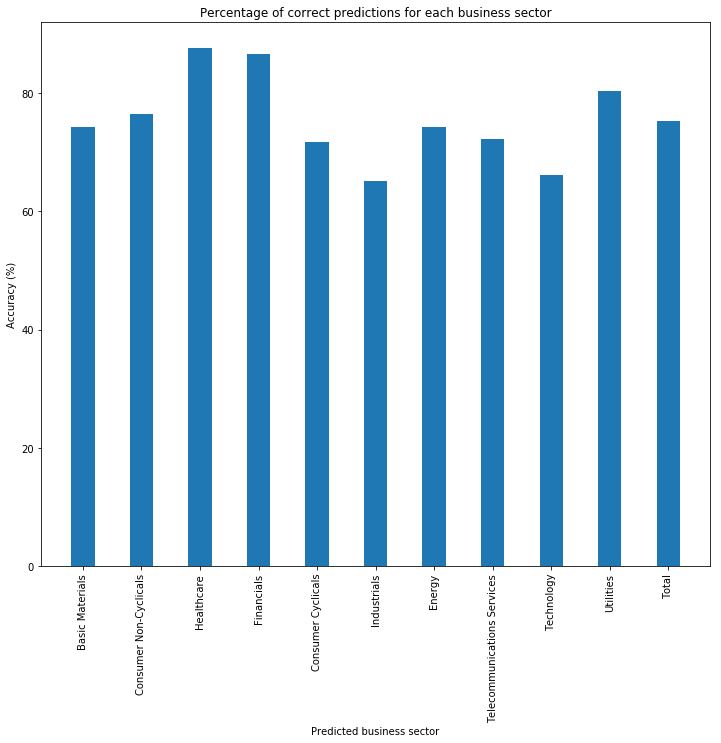

In [44]:
# calculate sector-specific accuracy
accuracy = np.zeros(N)
for s,sec in enumerate(sectors):
    secPredicts = (testPredictMLE.values == sec)
    accuracy[s] = float(((testPredictMLE.values == testData.econSec.values)*secPredicts).sum()) / secPredicts.sum() * 100

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.bar(range(0, 2*(N+1), 2),np.append(accuracy,accuracyTotal))
plt.title('Percentage of correct predictions for each business sector')
plt.xlabel('Predicted business sector')
plt.ylabel('Accuracy (%)')
plt.xticks(range(0,2*(N+1),2), np.append(sectors,'Total'), rotation='vertical')
plt.show()

We find that our model is correct nearly 90% of the time when it predicts the sector to be 'Healthcare' or 'Financials', but is correct only ~65% of the time when it predicts 'Technology' or 'Industrials'. The discrepancy here could be due to a difference in the number of unique keywords broadly associated with each of these industries. It may also be due to the fact that businesses in many industries are likely to include technological keywords in their descriptions, leading to misclassifications.